For a Hilbert space truncation $M$ and a detector with $N$ outcomes the m

$$
\min_{\Pi}|| P - F\Pi ||_2 + g(\Pi)
$$

where $F \in \mathbb{R}^{D\times N}$

In [1]:
from functools import partial

import numpy as np
from scipy.stats import poisson
import optuna
import matplotlib.pyplot as plt
import torch as th
from torch import vstack, tensor


from loss import phase_insensitive_loss_cvx
from quantum import pnr_povm, diag_povm_fidelity, photodetector_povm
from tune import objective
from utils import check_diag_povm, find_lambda_for_poisson

In [2]:
N = 50  # number of POVM outcomes
M = 100  # Hilbert space dimension

### True POVMs

NOTE: Column `j` of `true_povm` correspond to diagonal of POVM element $E_j$. The rows of `true_povm` are probability vectors, rows should sum to 1. 

In [3]:
# random POVM
# logits = th.rand((M, N)) - 1  # uniform random range (-1,1)
# true_povm = th.softmax(logits, dim=1).to(dtype=th.float64) 

# PNR detector POVM
true_povm = pnr_povm(hilbert_dim=M, N=N, eta=0.9)
true_povm = vstack( [th.diagonal(E) for E in true_povm] ).T

# Bucket detector POVM
# true_povm = photodetector_povm(hilbert_dim=M, eta=0.5)
# true_povm = vstack( [th.diagonal(E) for E in true_povm] ).T


print(f"First row sum is: {sum(true_povm[0, :]).item()}")
print(f"Number of POVM elements: {true_povm.shape[1]}, should be N={true_povm.shape[1]}")
print(f"Shape of Π is: {tuple(true_povm.shape)} should be (M={M}, N={true_povm.shape[1]})")
print(f'Is true POVM valid? {"Yes" if check_diag_povm(true_povm.T, tol=1e-6) else "No"}')

First row sum is: 1.0
Number of POVM elements: 51, should be N=51
Shape of Π is: (100, 51) should be (M=100, N=51)
Is true POVM valid? Yes


### Probe states

Create matrix, $F$, of probe state probabilities (Poissonian PMF since we are using coherent states).

In [ ]:
D = 250  # D is number of probes
max_avg = find_lambda_for_poisson(M, max_lambda=M, threshold=1e-5)

print(f"Max average photon number will be {max_avg:.2f} while Hilbert space cutoff is {M}.")
print(f"Is probability at M={M} ≤ 10^-5?: { 'Yes' if poisson.pmf(M, max_avg) <= 1e-5 else 'No' }")
n_bars = np.linspace(0, max_avg, D)

probes = tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars ])) 
print(f"Shape of probes is: {tuple(probes.shape)} should be (D={D}, M={M}).")

Max average photon number will be 0.00 while Hilbert space cutoff is 100.
Is probability at M=100 ≤ 10^-5?: Yes
Shape of probes is: (250, 100) should be (D=250, M=100).


### Target matrix 

Create target matrix $P$

In [33]:
targets = probes @ true_povm  

print(f"Shape of targets is: {tuple(targets.shape)} should be (D={D}, N={true_povm.shape[1]})")

for i in range(targets.shape[1]):
    if th.sum(targets[0][i]).item() - 1.0 > 1e-6:
        print(f"Warning: Sum of target probabilities for probe {i} is {th.sum(targets[i]).item()} (should be 1.0)")

Shape of targets is: (250, 51) should be (D=250, N=51)


### Training

In [34]:
lam_smoothing = 1e-5 # regularization weight NOTE: This is actually detrimental when working with a perfect detector as the regulation is meant for imperfect ones...
# lr = 0.01  # learning rate
# iterations = 200
# beta1 = 0.99
# beta2 = 0.99
# lr_decay = 0.999  # learning rate decay factor
# batch_size = 16

num_trials = 30
device = 'cuda'

partial_objective_fn = partial(
    objective,
    probes=probes,
    targets=targets,
    lam_smoothing=lam_smoothing,
    device=device,
)

In [35]:
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=25),
)

study.optimize(partial_objective_fn, n_trials=num_trials)

best_trial = study.best_trial

logits, losses, lr_vals, iters = (
    best_trial.user_attrs["logits"],
    best_trial.user_attrs["losses"],
    best_trial.user_attrs["lr_vals"],
    best_trial.user_attrs["iters"],
)

[I 2025-11-01 17:17:01,414] A new study created in memory with name: no-name-574936ea-5dbe-42df-a342-0149e5d229c4
Learning POVM: 100%|██████████| 465/465 [00:05<00:00, 81.88it/s]
[I 2025-11-01 17:17:07,104] Trial 0 finished with value: 16.329784157483047 and parameters: {'lr': 0.00015371133240717948, 'lr_decay': 0.9073884007819486, 'beta1': 0.8724124253555954, 'beta2': 0.8596685352753197, 'num_epochs': 465, 'batch_size': 75}. Best is trial 0 with value: 16.329784157483047.
Learning POVM: 100%|██████████| 240/240 [00:02<00:00, 102.17it/s]
[I 2025-11-01 17:17:09,458] Trial 1 finished with value: 21.369536569939502 and parameters: {'lr': 0.002122367874128728, 'lr_decay': 0.9448576953744923, 'beta1': 0.9322591290767903, 'beta2': 0.8609475208503741, 'num_epochs': 240, 'batch_size': 95}. Best is trial 0 with value: 16.329784157483047.
Learning POVM: 100%|██████████| 315/315 [00:02<00:00, 143.49it/s]
[I 2025-11-01 17:17:11,659] Trial 2 finished with value: 32.75549231810062 and parameters: {'

Final loss: 8.93e-05


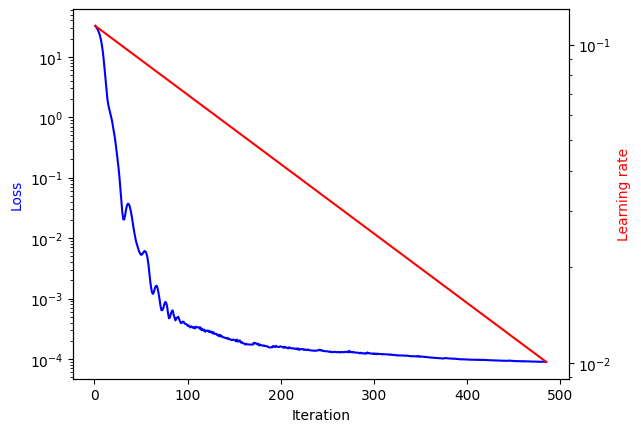

In [36]:
print(f"Final loss: {losses[-1]:.2e}")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(iters, losses, 'b-', label='Loss')
ax2.plot(iters, lr_vals, 'r-', label='Learning rate')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color='b')
ax1.set_yscale("log")
ax2.set_yscale("log")
ax2.set_ylabel('Learning rate', color='r')

plt.show();

In [37]:
with th.no_grad():
    probs = th.softmax(logits, dim=1).to('cpu')  # rows are probability vectors so apply softmax along them

    print(f'Is predicted POVM valid? {"Yes" if check_diag_povm(probs.T, tol=1e-5) else "No"}')

    Fs = [ diag_povm_fidelity(th.diag(probs[:, i]), true_povm[:, i]) for i in range(true_povm.shape[1]) ]
    print("Fidelities: ", Fs)
    print(f"Mean fidelity is {sum(Fs)/len(Fs)}")

Is predicted POVM valid? Yes
Fidelities:  [0.9994781896772645, 0.9975165929491383, 0.9921617433385419, 0.9859542773295226, 0.9792022754467674, 0.9764588575208516, 0.9763084821622376, 0.9761310217928518, 0.9771342323573832, 0.9690571359612153, 0.975934206552491, 0.9582414345576666, 0.9740286643639299, 0.978440809040439, 0.9723643219956075, 0.9769792276226377, 0.9769109814738317, 0.982153062710127, 0.9926326993779168, 0.9812757895656701, 0.9888401117174365, 0.9874787770893658, 0.9898613787077791, 0.9889649373507841, 0.9922444945980623, 0.9867658094261231, 0.989501769082425, 0.9890818590679267, 0.9892757083931799, 0.9913987719359729, 0.9910906936353644, 0.9864827458667499, 0.9868122301291179, 0.9849749041219759, 0.9803391863584945, 0.968792485659903, 0.9579811837991603, 0.974993843907573, 0.9852876829024351, 0.9784056181692362, 0.9724616862903787, 0.9806879610007144, 0.992537074875089, 0.9850760990271963, 0.9845557124538008, 0.9806442471768043, 0.98051894054014, 0.9409711704636722, 0.9508

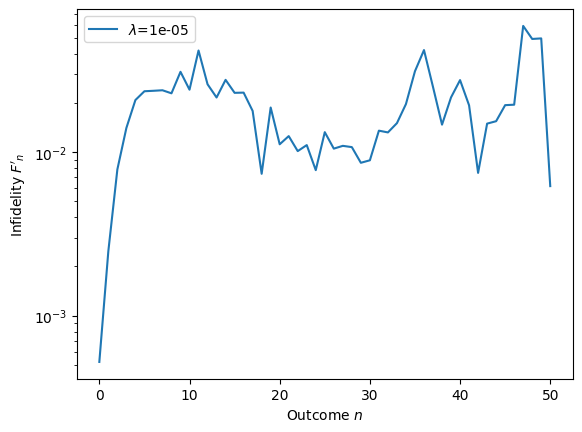

In [38]:
trunc_n = logits.shape[1]
plt.plot(list(range(trunc_n)), [1-F for F in Fs[:trunc_n]], label=rf"$\lambda$={lam_smoothing}")  # get infidelities

plt.legend()
plt.yscale("log")
plt.ylabel(r"Infidelity $F'_n$")
plt.xlabel(r"Outcome $n$");

## Convex optimization

In [39]:
solver = "MOSEK" # test SCS (PRL) & MOSEK (arXiv:2306.12622v1) or OSQP
Pi, prob, iters = phase_insensitive_loss_cvx(targets.cpu().numpy(), probes.cpu().numpy(), lam_smoothing, solver)

In [40]:
print(f"Took {solver} solver {iters} iterations to converge.")
print(f"Shape of Π is: {tuple(th.tensor(Pi).shape)} should be (M={M}, N={true_povm.shape[1]}).") 

Took MOSEK solver 21 iterations to converge.
Shape of Π is: (100, 51) should be (M=100, N=51).


In [41]:
print(f'Is predicted POVM valid? {"Yes" if check_diag_povm(tensor(Pi).T, tol=1e-5) else "No"}')

Fs = [ diag_povm_fidelity(tensor(Pi[:, i]), true_povm[:, i]) for i in range(true_povm.shape[1]) ]
print("Fidelities: ", Fs)
print(f"Mean fidelity is {sum(Fs)/len(Fs)}")

Is predicted POVM valid? Yes
Fidelities:  [0.999497582405463, 0.9984662143789197, 0.991090105639292, 0.9835917290464162, 0.9828171000739158, 0.9768238628667952, 0.9755483404763539, 0.9775475678657339, 0.9768754896163849, 0.9783145381888956, 0.9805366359239428, 0.9823665744693056, 0.9847215437271865, 0.9865514157994838, 0.9887436003128498, 0.9909815204870766, 0.9925540456843693, 0.9938973257050726, 0.9955441974394238, 0.9965644247173022, 0.9968905604244996, 0.9970446252347746, 0.9972017777557702, 0.9974337585650719, 0.9976538485544639, 0.9977887685360837, 0.9979131065819337, 0.9980619559529065, 0.9982381073954372, 0.9984048620014261, 0.9985305720597367, 0.9986062680206675, 0.9986389895800297, 0.998656632453055, 0.9986563183060188, 0.9986147458578544, 0.9985352949015092, 0.9984275988653721, 0.9982640597212469, 0.9979903444899741, 0.9977347357850123, 0.9973915559507079, 0.9969558949830153, 0.9962784496926448, 0.995313275395067, 0.9944958241939998, 0.9940860335996005, 0.9939830616937355, 0

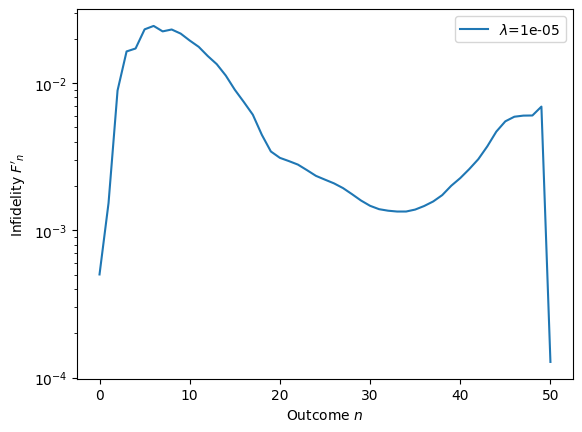

In [42]:
trunc_n = Pi.shape[1]
plt.plot(list(range(trunc_n)), [1-F for F in Fs[:trunc_n]], label=rf"$\lambda$={lam_smoothing}")  # get infidelities

plt.legend()
plt.yscale("log")
plt.ylabel(r"Infidelity $F'_n$")
plt.xlabel(r"Outcome $n$");